# 4.4 Evaluating models


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics
from matplotlib import pyplot

plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
sns.set_style("white")

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- RECAP FROM LAST SECTION

- Talk about general ways of doing model evaluation in ML

In [2]:
datafolder = '../m3/data/UKDA-7724-csv/'
df11 = pd.read_csv(datafolder + 'csv/eqls_2011.csv')
df_map = pd.read_csv(datafolder + 'mrdoc/excel/eqls_api_map.csv', encoding='latin1')

In [3]:
# we are only interested in the UK for this example.
df11 = df11.query('Y11_Country == 27')

var_map = {"Y11_Q42": "SRH",
           'Y11_Deprindex': 'DeprIndex',
           "Y11_RuralUrban": "RuralUrban",
           "Y11_Accommproblems": 'AccomProblems',
           "Y11_HHsize": "HouseholdSize",
           "Y11_Q32": "Children",
           "Y11_ISCEDsimple":"ISCED",
           "Y11_Education": "Education",
           "Y11_SocExIndex":"SocialExclusionIndex",
           "Y11_MWIndex": "MentalWellbeingIndex",
           "Y11_Agecategory":"AgeCategory",
           "Y11_HH2a":"Gender",
           "Y11_Q31":"MaritalStatus",
           "Y11_Country":"Country"
}

df11.rename(columns=var_map, inplace=True)
df11_set = df11[var_map.values()]

df11_model = df11_set.dropna() 

# dichotomoise SRH
df11_model['SRH_binary'] = df11_model.SRH.apply(lambda x: 1 if float(x) <= 3 else 0)

/anaconda3/envs/rds-course/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Model 1: 
- Start with simple model
- Talk about test and train split

In [4]:
trainX_model1, testX_model1, trainy_model1, testy_model1 = train_test_split(df11_model[['AgeCategory','DeprIndex']], df11_model.SRH_binary.values, test_size=0.3, random_state=2)

In [5]:
trainX_const_model1 = sm.add_constant(trainX_model1) #add constant for intercept
logit_model_model1 = sm.Logit(trainy_model1, trainX_const_model1) #Create model instance
result_model1 = logit_model_model1.fit() #Fit model

print (result_model1.summary())

Optimization terminated successfully.
         Current function value: 0.325243
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1392
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:                 0.08318
Time:                        15:00:30   Log-Likelihood:                -453.71
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 1.323e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0847      0.349     11.692      0.000       3.400       4.769
AgeCategory    -0.4030    

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


- Talk about confusion matrices, accuracy, precision, recall

Accuracy: 0.8931552587646077
Precision: 0.8961474036850922
Recall: 0.9962756052141527


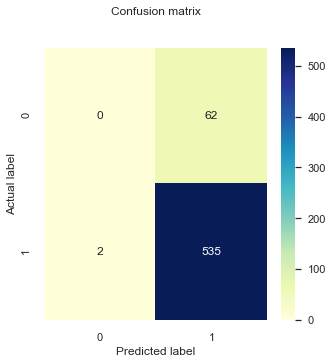

In [6]:
# performing predictions on the test datdaset
pred_y_model1 = list(map(round, result_model1.predict(sm.add_constant(testX_model1))))


cnf_matrix = metrics.confusion_matrix(testy_model1,pred_y_model1)

def plt_cnf_mat(cnf_matrix, ax, class_names=[0,1]):
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.set_title('Confusion matrix', y=1.1)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    
    
fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix, ax)


print("Accuracy:",metrics.accuracy_score(testy_model1, pred_y_model1))
print("Precision:",metrics.precision_score(testy_model1, pred_y_model1))
print("Recall:",metrics.recall_score(testy_model1, pred_y_model1)) # what is recall? 

You can see here the no negative values get predicted and the overwelming majority of responses are true positives. Let's get this as a proportion of amount of actual labels in of each category.

- Discuss what is happening above, motivate for another way of measuring performace.

- What Are ROC Curves?

- Useful tool in this case 

- ROC metrics, compare with dummy classifier

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.766


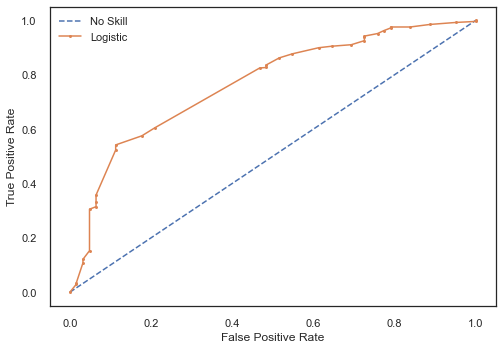

In [7]:
lr_probs_model1 = result_model1.predict(sm.add_constant(testX_model1))

ns_probs_model1 = [0 for _ in range(len(testy_model1))]
# keep probabilities for the positive outcome only
# calculate scores
ns_auc_model1 = roc_auc_score(testy_model1, ns_probs_model1)
lr_auc_model1 = roc_auc_score(testy_model1, lr_probs_model1)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc_model1))
print('Logistic: ROC AUC=%.3f' % (lr_auc_model1))
# calculate roc curves
ns_fpr_model1, ns_tpr_model1, _ = roc_curve(testy_model1, ns_probs_model1)
lr_fpr_model1, lr_tpr_model1, _ = roc_curve(testy_model1, lr_probs_model1)
# plot the roc curve for the model
pyplot.plot(ns_fpr_model1, ns_tpr_model1, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_model1, lr_tpr_model1, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- Talk about limitation of previous model

- Make a more complicated model with more variables

## Model 2

In [8]:
trainX_model2, testX_model2, trainy_model2, testy_model2 = train_test_split(df11_model[['AgeCategory','DeprIndex','Education','Children',"AccomProblems"]], df11_model.SRH_binary.values, test_size=0.3, random_state=2)
trainX_const_model2 = sm.add_constant(trainX_model2) #add constant for intercept
logit_model2 = sm.Logit(trainy_model2, trainX_const_model2) #Create model instance
result_model2 = logit_model2.fit() #Fit model

Optimization terminated successfully.
         Current function value: 0.317270
         Iterations 7


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Accuracy: 0.8998330550918197
Precision: 0.9008403361344538
Recall: 0.9981378026070763


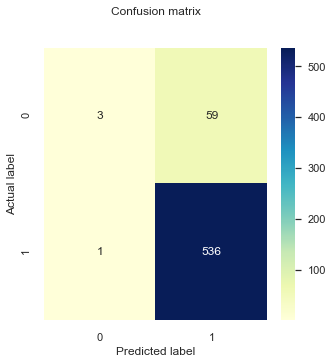

In [9]:
# performing predictions on the test datdaset
pred_y_model2 = list(map(round, result_model2.predict(sm.add_constant(testX_model2))))


cnf_matrix_model2  = metrics.confusion_matrix(testy_model2,pred_y_model2)

fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix_model2 , ax)


print("Accuracy:",metrics.accuracy_score(testy_model2 , pred_y_model2 ))
print("Precision:",metrics.precision_score(testy_model2 , pred_y_model2 ))
print("Recall:",metrics.recall_score(testy_model2 , pred_y_model2 )) # what is recall? 

In [10]:
print (result_model2.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1389
Method:                           MLE   Df Model:                            5
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:                  0.1057
Time:                        15:00:30   Log-Likelihood:                -442.59
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 5.722e-21
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.9090      0.577      5.044      0.000       1.779       4.039
AgeCategory      -0.3567      0.088     -4.064      0.000      -0.529      -0.185
DeprIndex        -0.2995      0.046     

- Discuss Log-Likelihood as another way of measuring model performance (and comparing between models)

No Skill: ROC AUC=0.500
Logistic Simple Model: ROC AUC=0.766
Logistic: ROC AUC=0.763


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


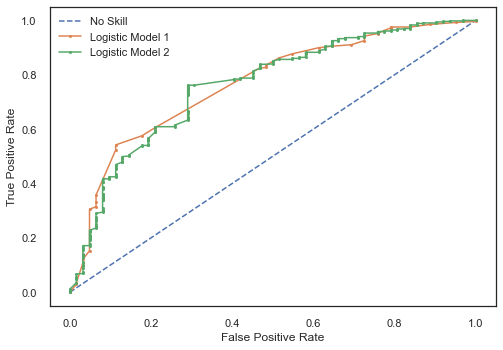

In [11]:
lr_probs_model2  = result_model2.predict(sm.add_constant(testX_model2 ))

ns_probs_model2 = [0 for _ in range(len(testy_model2))]
# keep probabilities for the positive outcome only
# calculate scores
ns_auc_model2  = roc_auc_score(testy_model2 , ns_probs_model2 )
lr_auc_model2  = roc_auc_score(testy_model2 , lr_probs_model2 )
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc_model2))
print('Logistic Simple Model: ROC AUC=%.3f' % (lr_auc_model1))
print('Logistic: ROC AUC=%.3f' % (lr_auc_model2))
# calculate roc curves
ns_fpr_model2 , ns_tpr_model2 , _ = roc_curve(testy_model2, ns_probs_model2)
lr_fpr_model2 , lr_tpr_model2 , _ = roc_curve(testy_model2, lr_probs_model2)
# plot the roc curve for the model
pyplot.plot(ns_fpr_model2, ns_tpr_model2, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_model1, lr_tpr_model1, marker='.', label='Logistic Model 1 ')
pyplot.plot(lr_fpr_model2, lr_tpr_model2, marker='.', label='Logistic Model 2')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- Talk about information gained from more complicated model. 

- Go back to our research question: talk about how to know that a variable has importance in the model.

## Model 3

- Add a couple more variables:
    - Mental health
    - Social exclusion
    - Disucus how these variables were taken.

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.273457
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1387
Method:                           MLE   Df Model:                            7
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:                  0.2292
Time:                        15:00:30   Log-Likelihood:                -381.47
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 2.356e-45
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.2443      0.809      2.775      0.006       0.659       3.830

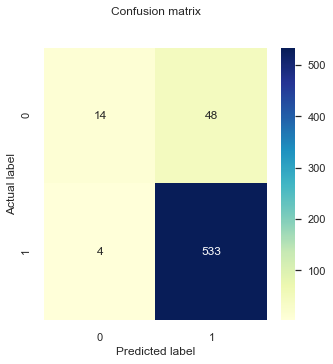

In [12]:
X = df11_model[['AgeCategory','DeprIndex','Education','MentalWellbeingIndex','Children',"SocialExclusionIndex","AccomProblems"]]
y = df11_model.SRH_binary.values

trainX_model3, testX_model3, trainy_model3, testy_model3 = train_test_split(X, y, test_size=0.3, random_state=2)
trainX_const_model3 = sm.add_constant(trainX_model3) #add constant for intercept
logit_model3 = sm.Logit(trainy_model3, trainX_const_model3) #Create model instance
result_model3 = logit_model3.fit() #Fit model


print (result_model3.summary())

# performing predictions on the test datdaset
pred_y_model3 = list(map(round, result_model3.predict(sm.add_constant(testX_model3))))


cnf_matrix_model3 = metrics.confusion_matrix(testy_model3,pred_y_model3)

fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix_model3, ax)


print("Accuracy:",metrics.accuracy_score(testy_model3, pred_y_model3))
print("Precision:",metrics.precision_score(testy_model3, pred_y_model3))
print("Recall:",metrics.recall_score(testy_model3, pred_y_model3)) # what is recall? 


- Discuss improvement in classification, and log likelihood.

No Skill: ROC AUC=0.500
Logistic Simple Model: ROC AUC=0.766
Logistic: ROC AUC=0.808


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


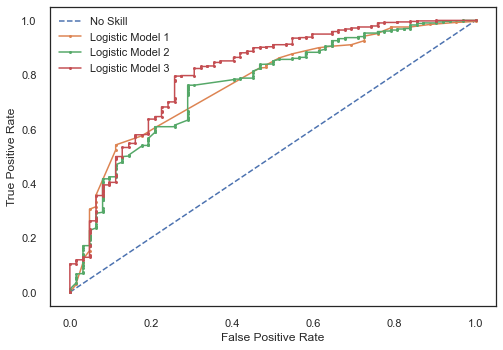

In [15]:
lr_probs_model3 = result_model3.predict(sm.add_constant(testX_model3))

ns_probs_model3 = [0 for _ in range(len(testy_model3))]
# keep probabilities for the positive outcome only
# calculate scores
lr_auc_model3 = roc_auc_score(testy_model3, lr_probs_model3)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc_model2))
print('Logistic Simple Model: ROC AUC=%.3f' % (lr_auc_model1))
print('Logistic: ROC AUC=%.3f' % (lr_auc_model3))
# calculate roc curves
ns_fpr_model3, ns_tpr_model3, _ = roc_curve(testy_model3, ns_probs_model3)
lr_fpr_model3, lr_tpr_model3, _ = roc_curve(testy_model3, lr_probs_model3)
# plot the roc curve for the model
pyplot.plot(ns_fpr_model3, ns_tpr_model3, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_model1, lr_tpr_model1, marker='.', label='Logistic Model 1')
pyplot.plot(lr_fpr_model2, lr_tpr_model2, marker='.', label='Logistic Model 2')
pyplot.plot(lr_fpr_model3, lr_tpr_model3, marker='.', label='Logistic Model 3')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- Discuss what the Aldabe paper does.